In [29]:
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from scipy.stats import gaussian_kde
import seaborn as sns
import re

import importlib
import toylosses
importlib.reload(toylosses)
import toynn
importlib.reload(toynn)
import toyvis
importlib.reload(toyvis)

import torch
sns.set()

DEVICE = 'cuda'
OUTPUT = '/scratch/users/nmiolane/toyoutput_180409a'

# Inspect generation of synthetic data from decoder_true

In [11]:
w_true = 2
color_true = 'green'
def generate_synthetic_1d(w=w_true, n=10):
    z = np.random.normal(loc=0, scale=1, size=(n, 1))
    eps = np.random.normal(loc=0, scale=1, size=(n, 1))

    x = w * z + eps
    return x

In [3]:
decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)
assert decoder_true.layers[0].weight[0, 0] == w_true

for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')

layers.0.weight tensor([[2.]], device='cuda:0') 



Covariance matrix from decoder:
5.174616839917996
Covariance matrix from synthetic:
4.905543167070465


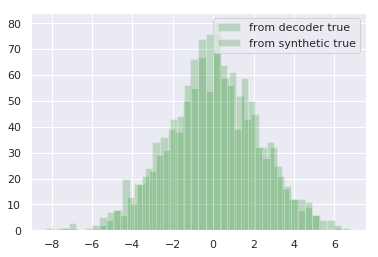

In [4]:
n_samples = 1000

synthetic_x = generate_synthetic_1d(w=w_true, n=n_samples)
generated_true_x = toynn.generate_from_decoder(decoder_true, n_samples)

fig, ax = plt.subplots()
ax = toyvis.plot_data(generated_true_x, color='green', label='from decoder true', ax=ax)
ax = toyvis.plot_data(synthetic_x, color='green', label='from synthetic true', ax=ax)
ax.legend(loc='upper right')

print('Covariance matrix from decoder:')
cov = np.cov(generated_true_x.T)
print(cov)

print('Covariance matrix from synthetic:')
cov = np.cov(synthetic_x.T)
print(cov)

# Inspect results from standard VAE

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[1.0987]], device='cuda:0') 

Last losses:
[0.04121307018399239, 0.04090024897456169, 0.04072944913804531, 0.04138818988204002, 0.04098958967626095]


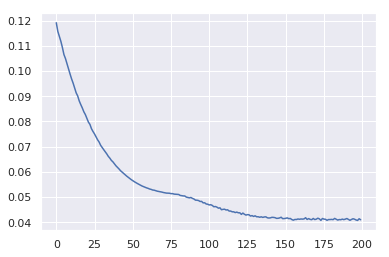

In [4]:
decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

decoder_path = glob.glob(f'{OUTPUT}/train_vae/models/decoder.pth')[0]
decoder = torch.load(decoder_path, map_location=DEVICE)

print('-- True values of parameters')
for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')

print('\n-- Learnt values of parameters')
for name, param in decoder.named_parameters():
    print(name, param.data, '\n')
    
losses_vae_path = glob.glob(f'{OUTPUT}/train_vae/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(losses_vae_path, 'rb'))

plt.figure()
train_losses_total = [loss['total'] for loss in train_losses_all_epochs]
n_epochs = len(train_losses_total)
plt.plot(range(n_epochs), train_losses_total)
print('Last losses:')
print(train_losses_total[-5:])

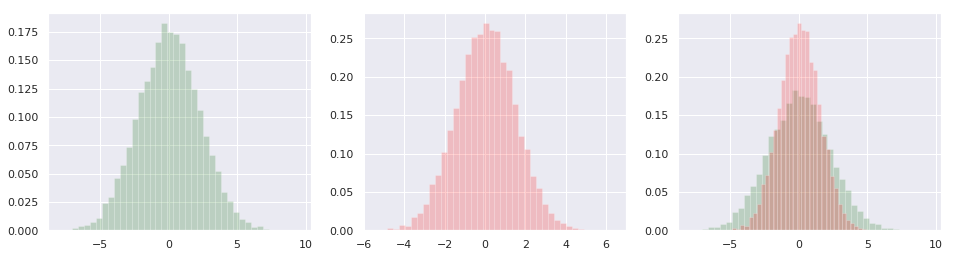

In [33]:
n_samples = 10000
generated_true_x = toynn.generate_from_decoder(decoder_true, n_samples)
generated_x = toynn.generate_from_decoder(decoder, n_samples)

# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

ax = axes[1]
toyvis.plot_data(generated_x, color='red', ax=ax)

ax = axes[2]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax, label='true')
toyvis.plot_data(generated_x, color='red', ax=ax, label='vae estimate')

# Inspect the inference on the posterior

In [20]:
encoder_path = glob.glob(f'{OUTPUT}/train_vae/models/encoder.pth')[0]
encoder = torch.load(encoder_path, map_location=DEVICE)

print('\n-- Optimal value for phi')
phi_opt = w_true / (w_true ** 2 + 1)
print(phi_opt)

print('\n-- Learnt values of parameters')
for name, param in encoder.named_parameters():
    print(name, param.data, '\n')
    
phi_encoder = encoder.fc1.weight.data.cpu().numpy()[0,0]
print(phi_encoder)


-- Optimal value for phi
0.4

-- Learnt values of parameters
fc1.weight tensor([[0.4968]], device='cuda:0') 

0.49675614


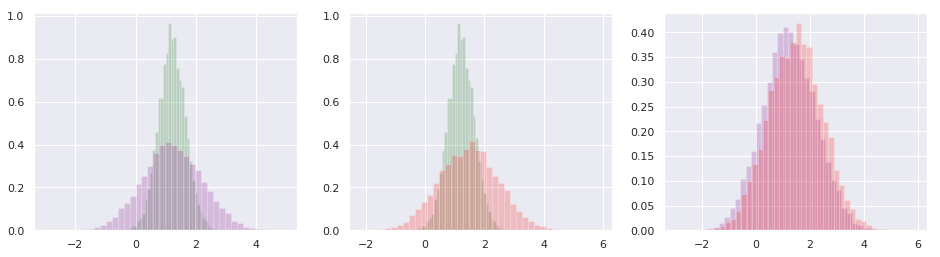

In [35]:
n_to_sample = 10000

x = 3
true_loc = w_true / (w_true ** 2 + 1) * x
true_scale = 1/ np.sqrt((1 + w_true ** 2))
z_true_posterior = np.random.normal(loc=true_loc, scale=true_scale, size=(n_to_sample, 1))
z_opt_posterior = np.random.normal(loc=true_loc, scale=1, size=(n_to_sample, 1))
z_encoder = np.random.normal(loc=phi_encoder*x, scale=1, size=(n_to_sample, 1)) 
                        
# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
ax = toyvis.plot_data(z_true_posterior, color='darkgreen', ax=ax)
ax = toyvis.plot_data(z_opt_posterior, color='purple', ax=ax)

ax = axes[1]
toyvis.plot_data(z_true_posterior, color='darkgreen', ax=ax)
toyvis.plot_data(z_encoder, color='red', ax=ax)

ax = axes[2]
toyvis.plot_data(z_opt_posterior, color='purple', ax=ax)
toyvis.plot_data(z_encoder, color='red', ax=ax)

# Inspect results from VEM

-- True values of parameters
layers.0.weight tensor([[2.]], device='cuda:0') 


-- Learnt values of parameters
layers.0.weight tensor([[0.0350]], device='cuda:0') 

Last losses:
[0.0851159046292305, 0.08510567712783813, 0.08511399310827256, 0.08511706686019897, 0.08512264275550842]


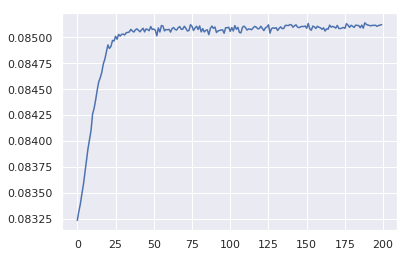

In [7]:
decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

decoder_path = glob.glob(f'{OUTPUT}/train_vem/models/decoder.pth')[0]
decoder = torch.load(decoder_path, map_location=DEVICE)

print('-- True values of parameters')
for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')

print('\n-- Learnt values of parameters')
for name, param in decoder.named_parameters():
    print(name, param.data, '\n')
    
losses_vae_path = glob.glob(f'{OUTPUT}/train_vem/train_losses.pkl')[0]
train_losses_all_epochs = pickle.load(open(losses_vae_path, 'rb'))

plt.figure()
train_losses_total = [loss['total'] for loss in train_losses_all_epochs]
n_epochs = len(train_losses_total)
plt.plot(range(n_epochs), train_losses_total)
print('Last losses:')
print(train_losses_total[-5:])

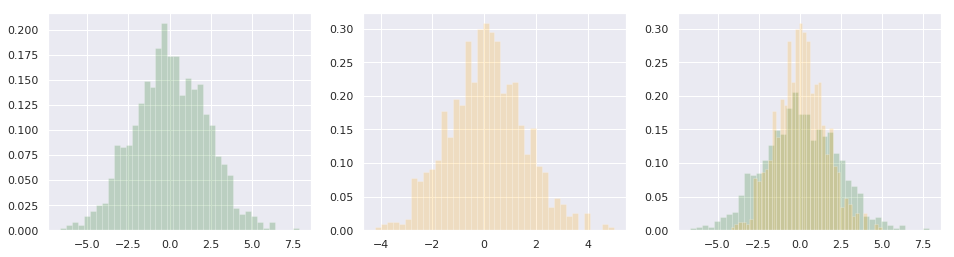

In [34]:
n_samples = 1000
generated_true_x = toynn.generate_from_decoder(decoder_true, n_samples)
generated_x = toynn.generate_from_decoder(decoder, n_samples)

# For 1D
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 4))
axis_side = 20

ax = axes[0]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)

ax = axes[1]
toyvis.plot_data(generated_x, color='orange', ax=ax)

ax = axes[2]
toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)
toyvis.plot_data(generated_x, color='orange', ax=ax)

# Print pipeline logs

In [9]:
pattern = 'logs'
logs = []
for filename in os.listdir(OUTPUT):
    if re.search(pattern, filename):
        logs.append(filename)

for filename in logs:
    path = os.path.join(OUTPUT, filename)
    print('\n-- Log file: %s\n' % filename)
    with open(path, 'r') as f:
        message = f.read()
    print(message)


-- Log file: logs2019-04-09 20:43:29.033664.txt

2019-04-09 20:43:29,033 root         INFO     start
2019-04-09 20:43:29,048 luigi        INFO     logging configured by default settings
2019-04-09 20:43:29,071 luigi-interface DEBUG    Checking if RunAll() is complete
2019-04-09 20:43:29,072 luigi-interface DEBUG    Checking if TrainVAE() is complete
2019-04-09 20:43:29,072 luigi-interface DEBUG    Checking if TrainVEM() is complete
2019-04-09 20:43:29,073 luigi-interface INFO     Informed scheduler that task   RunAll__99914b932b   has status   PENDING
2019-04-09 20:43:29,073 luigi-interface DEBUG    Checking if MakeDataSet() is complete
2019-04-09 20:43:29,074 luigi-interface INFO     Informed scheduler that task   TrainVEM__99914b932b   has status   PENDING
2019-04-09 20:43:29,074 luigi-interface INFO     Informed scheduler that task   MakeDataSet__99914b932b   has status   PENDING
2019-04-09 20:43:29,074 luigi-interface INFO     Informed scheduler that task   TrainVAE__99914b932b   